In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

In [149]:
def read_and_preprocess(file_path, event_code, target_date_str):
    df = pd.read_csv(file_path, header=1)
    
    df['Created Date'] = pd.to_datetime(df['Created Date'], dayfirst=True)
    df['Event'] = event_code

    target_date = pd.to_datetime(target_date_str, dayfirst=True)
    df['T_minus'] = (target_date - df['Created Date']).dt.days - 1 # excludes the target date

    # Filter out rows where T_minus is negative (i.e., created date is after the target date)
    df = df[df['T_minus'] >= 0]

    return df

In [150]:
def combine_datasets(*datasets):
    return pd.concat(datasets, ignore_index=True)


In [151]:
def plot_registrations_countdown(combined_data,tile):
    t_minus_registrations = combined_data.groupby('T_minus').size()
    plt.figure(figsize=(20, 6))
    plt.plot(t_minus_registrations.index, t_minus_registrations.values, marker='o', linestyle='-', color='b')
    plt.title(tile)
    plt.xlabel('Days Until Event (T-minus)')
    plt.ylabel('Number of Registrations')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [152]:
def calculate_daily_registrations(combined_data):
    daily_registrations = combined_data.groupby('Created Date').size().reset_index(name='Total Registrations')
    daily_registrations['Z-Score'] = (daily_registrations['Total Registrations'] - daily_registrations['Total Registrations'].mean()) / daily_registrations['Total Registrations'].std()
    daily_registrations['Advertisement'] = (daily_registrations['Z-Score'] > 1).astype(int)
    return daily_registrations

In [153]:
def prepare_for_forecasting(daily_registrations):
    first_date = daily_registrations['Created Date'].min()
    last_date = daily_registrations['Created Date'].max()
    date_range = pd.DataFrame(pd.date_range(start=first_date, end=last_date), columns=['Date'])
    complete_reg = pd.merge(date_range, daily_registrations, left_on='Date', right_on='Created Date', how='left', sort=True)
    complete_reg.drop(columns=['Created Date'], inplace=True)
    complete_reg['Total Registrations'].fillna(0, inplace=True)
    complete_reg['Z-Score'].fillna(0, inplace=True)
    complete_reg['Advertisement'].fillna(0, inplace=True)
    complete_reg['Date'] = pd.to_datetime(complete_reg['Date'])
    complete_reg = complete_reg.set_index('Date')
    return complete_reg


In [154]:
def split_data_for_forecasting(complete_reg, split_ratio=0.8):
    train_size = int(len(complete_reg) * split_ratio)
    train = complete_reg.iloc[:train_size]
    test = complete_reg.iloc[train_size:]

    train_endog = train['Total Registrations']
    train_exog = train[['Advertisement']]
    test_endog = test['Total Registrations']
    test_exog = test[['Advertisement']]

    return train_endog, train_exog, test_endog, test_exog

def auto_arima_forecasting(endog, exog):
    auto_model = auto_arima(endog, exogenous=exog, seasonal=True, m=7, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
    print(auto_model.summary())
    return auto_model.order, auto_model.seasonal_order

def sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order):
    model = SARIMAX(train_endog, order=order, seasonal_order=seasonal_order, exog=train_exog)
    results = model.fit()
    print(results.summary())
    forecast_results = results.get_forecast(steps=len(test_exog), exog=test_exog)
    return forecast_results.predicted_mean, forecast_results.conf_int()


In [155]:
def plot_forecast_vs_actuals(train, test, forecast_values, conf_int):
    
    # Plotting
    plt.figure(figsize=(30, 6))

    # Plot the observed values
    plt.plot(train.index, train['Total Registrations'], label='Train', color='blue')
    plt.plot(test.index, test['Total Registrations'], label='Test', color='green')

    # Plot the forecasted values
    plt.plot(test.index, forecast_values, label='Forecast', color='red')

    # Plot the confidence interval
    plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Total Registrations')
    plt.title('SARIMAX Model Forecast vs Actuals')
    plt.legend()
    plt.show()

In [156]:
'''import matplotlib.ticker as ticker

def plot_forecast_vs_actuals(train, test, forecast_values, conf_int):
    # Resample the data to weekly frequency
    weekly_train = train.resample('W').sum()['Total Registrations']
    weekly_test = test.resample('W').sum()['Total Registrations']
    
    # Create week labels for the train set
    train_week_labels = [f"Week {i+1}" for i in range(len(weekly_train))]
    
    # Create week labels for the test set
    test_week_labels = [f"Week {i+1+len(train_week_labels)}" for i in range(len(weekly_test))]

    # Combine the week labels
    all_week_labels = train_week_labels + test_week_labels
    
    # Plotting
    plt.figure(figsize=(30, 6))

    # Plot the observed values with the new week labels
    plt.plot(train_week_labels, weekly_train, label='Train', color='blue')
    plt.plot(test_week_labels, weekly_test, label='Test', color='green')

    # Ensure forecast_values and conf_int are pandas Series with a DateTimeIndex
    forecast_values.index = pd.to_datetime(forecast_values.index)
    conf_int.index = pd.to_datetime(conf_int.index)
    
    # Resample forecast_values and conf_int to weekly
    weekly_forecast_values = forecast_values.resample('W').sum()
    weekly_conf_int = conf_int.resample('W').sum()

    # Plot the forecasted values with the new week labels
    plt.plot(test_week_labels, weekly_forecast_values, label='Forecast', color='red')

    # Plot the confidence interval
    plt.fill_between(test_week_labels, 
                     weekly_conf_int.iloc[:, 0], weekly_conf_int.iloc[:, 1], 
                     color='pink', alpha=0.3)

    # Set labels and title
    plt.xlabel('Week Number')
    plt.ylabel('Total Registrations')
    plt.title('Weekly Aggregated SARIMAX Model Forecast vs Actuals')
    plt.legend()

    # Set x-axis to show every week label
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.AutoLocator())

    plt.tight_layout()
    plt.show()'''

'import matplotlib.ticker as ticker\n\ndef plot_forecast_vs_actuals(train, test, forecast_values, conf_int):\n    # Resample the data to weekly frequency\n    weekly_train = train.resample(\'W\').sum()[\'Total Registrations\']\n    weekly_test = test.resample(\'W\').sum()[\'Total Registrations\']\n    \n    # Create week labels for the train set\n    train_week_labels = [f"Week {i+1}" for i in range(len(weekly_train))]\n    \n    # Create week labels for the test set\n    test_week_labels = [f"Week {i+1+len(train_week_labels)}" for i in range(len(weekly_test))]\n\n    # Combine the week labels\n    all_week_labels = train_week_labels + test_week_labels\n    \n    # Plotting\n    plt.figure(figsize=(30, 6))\n\n    # Plot the observed values with the new week labels\n    plt.plot(train_week_labels, weekly_train, label=\'Train\', color=\'blue\')\n    plt.plot(test_week_labels, weekly_test, label=\'Test\', color=\'green\')\n\n    # Ensure forecast_values and conf_int are pandas Series with

In [157]:
# Using ARIMA

# Function to split the dataset into training and testing sets
def split_time_series_data(data, split_ratio=0.8):
    split_index = int(len(data) * split_ratio)
    train = data.iloc[:split_index]
    test = data.iloc[split_index:]
    return train, test

# Function to find the best ARIMA model order
def find_best_arima_order(endog):
    auto_model = auto_arima(endog, seasonal=False, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True, start_p=1, start_q=1, max_p=5, max_q=5, d=None, test='adf', start_P=0, D=0)
    print("Best ARIMA order:", auto_model.order)
    return auto_model.order

# Function to forecast using ARIMA
def arima_forecasting(endog, order):
    model = ARIMA(endog, order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    
    forecast_results = fitted_model.get_forecast(steps=len(test_endog_ar))
    forecast_values_arima = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()
    return forecast_values_arima, conf_int

In [158]:
# Using Exponential Smoothing
def exp_smoothing(endog, seasonal_periods = 7):
    model = ExponentialSmoothing(endog, trend = 'add', seasonal = 'add', seasonal_periods = seasonal_periods)
    fitted = model.fit()
    forecast_values_exp = fitted.forecast(steps = len(test_endog_exp))
    return forecast_values_exp

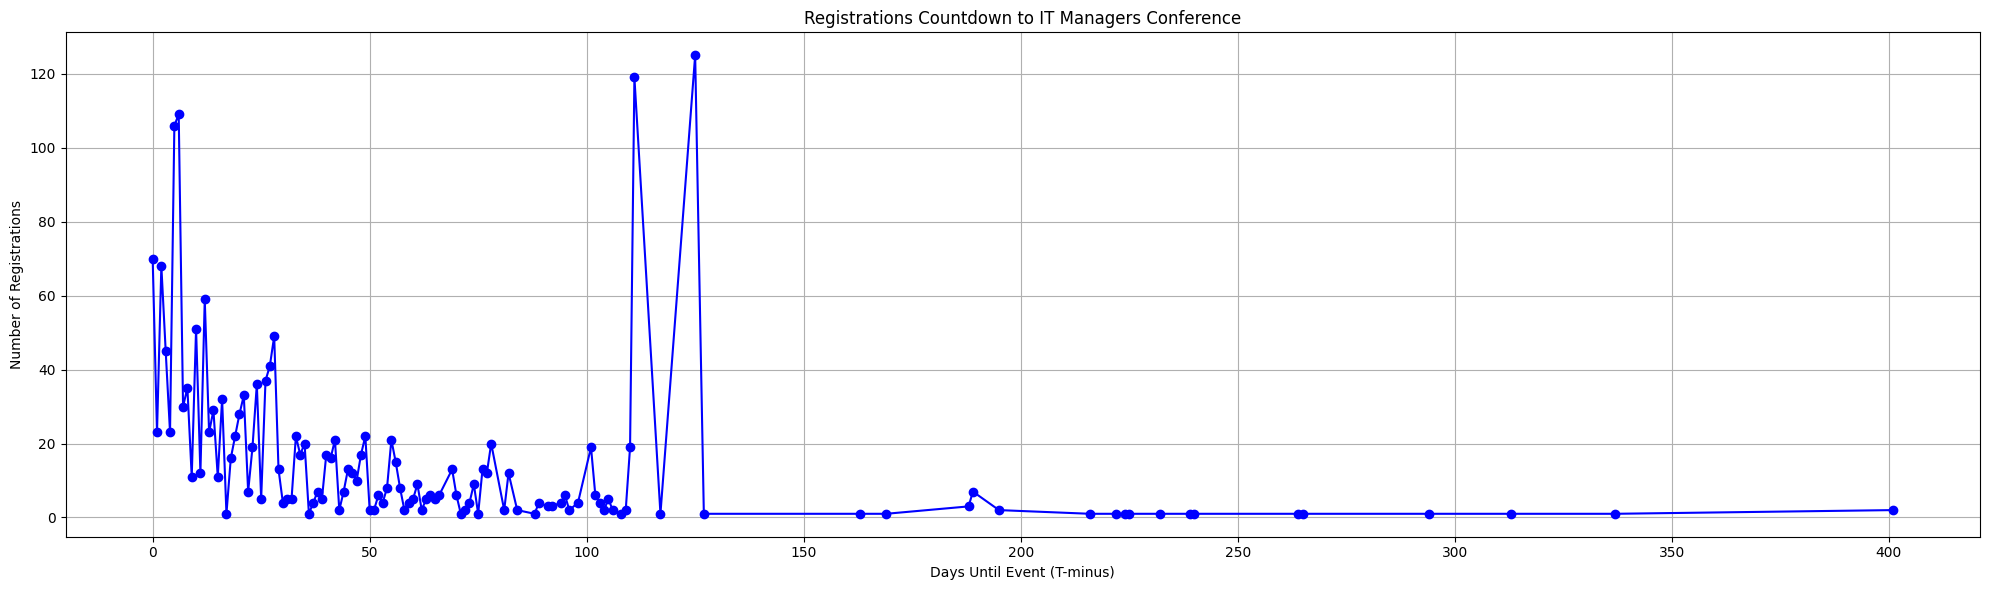

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5209.726, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5112.814, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5005.476, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5207.951, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5004.669, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=5004.431, Time=0.46 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=4901.999, Time=1.00 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=4900.626, Time=1.40 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=4962.241, Time=1.31 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=4902.604, Time=1.82 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=4910.344, Time=1.35 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=5123.395, Time=1.16 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=4.15 sec
 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=i

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                Total Registrations   No. Observations:                  701
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1976.986
Date:                            Wed, 21 Feb 2024   AIC                           3965.971
Time:                                    16:58:37   BIC                           3993.278
Sample:                                07-16-2019   HQIC                          3976.527
                                     - 06-15-2021                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    58.8398      0.343    171.458      0.000      58.167      59.512
ar.L1             0.2236  

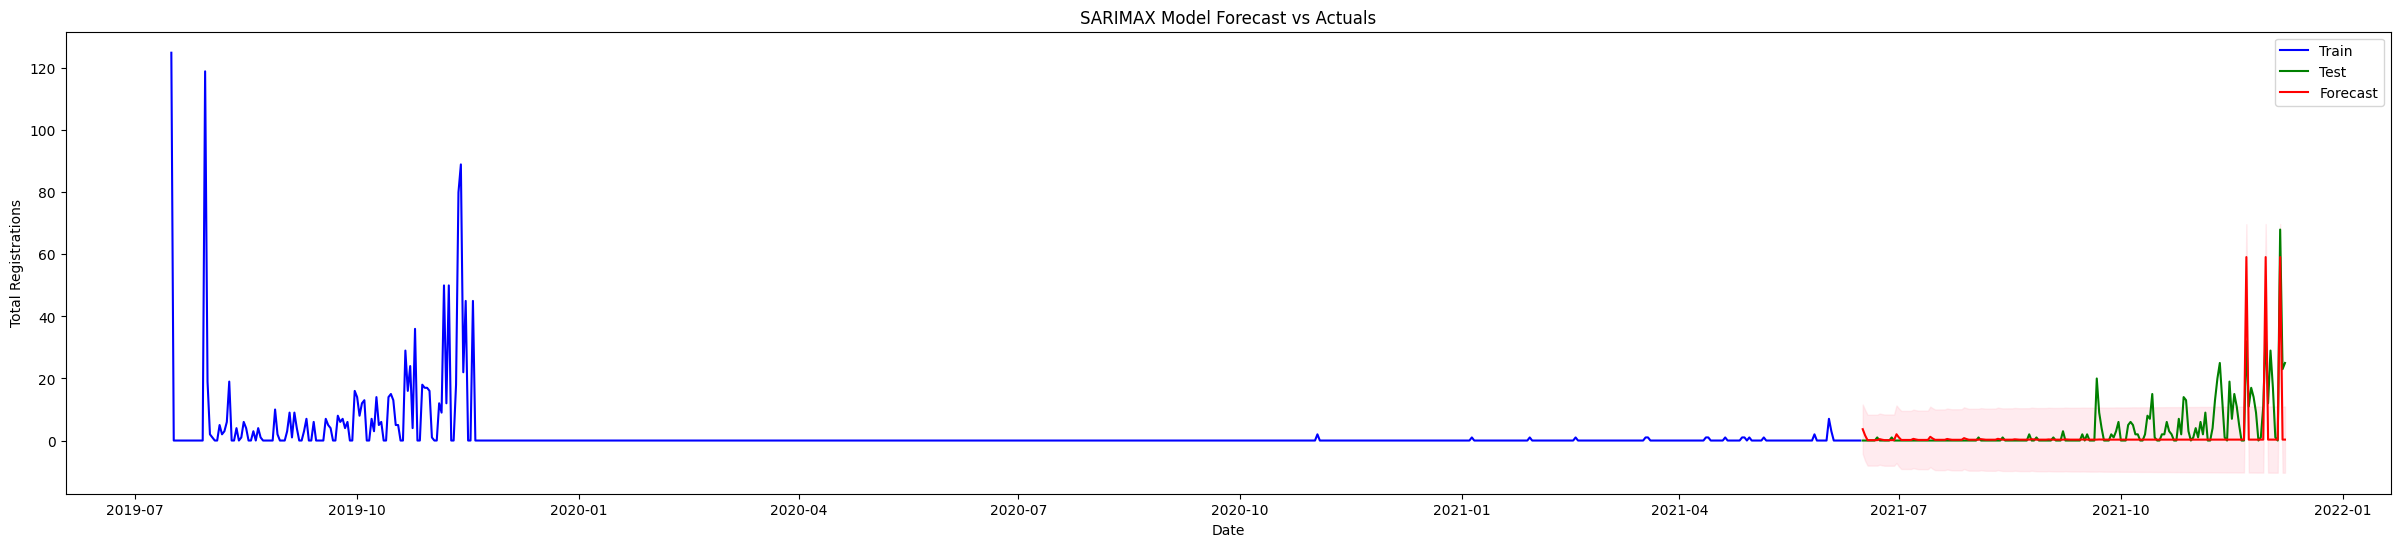

In [159]:
# IT Managers SARIMAX

# D19 & D21
d19 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D19.csv", 'D19', '19/11/2019')
d21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D21.csv", 'D21', '09/12/2021')

# Combine datasets
combined_it_managers = combine_datasets(d19, d21)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_it_managers, 'Registrations Countdown to IT Managers Conference')
daily_registrations_it = calculate_daily_registrations(combined_it_managers)
complete_reg_it = prepare_for_forecasting(daily_registrations_it)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_it)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_it.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5005.857, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5132.517, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5037.006, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5065.084, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4993.428, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5025.599, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4995.227, Time=0.56 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4995.312, Time=0.58 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4994.885, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=5025.325, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4990.539, Time=0.81 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=4992.356, Time=1.12 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=4999.137, Time=1.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4990.788, Time=0.66 sec
 ARIMA(4,0,1)(0,0,0)[0]          

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregre

                                SARIMAX Results                                
Dep. Variable:     Total Registrations   No. Observations:                  701
Model:                  ARIMA(4, 0, 3)   Log Likelihood               -2482.338
Date:                 Wed, 21 Feb 2024   AIC                           4982.675
Time:                         16:59:01   BIC                           5023.648
Sample:                     07-16-2019   HQIC                          4998.513
                          - 06-15-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8830     23.465      0.080      0.936     -44.108      47.874
ar.L1         -0.5136      0.037    -13.852      0.000      -0.586      -0.441
ar.L2          1.0412      0.017     61.259 

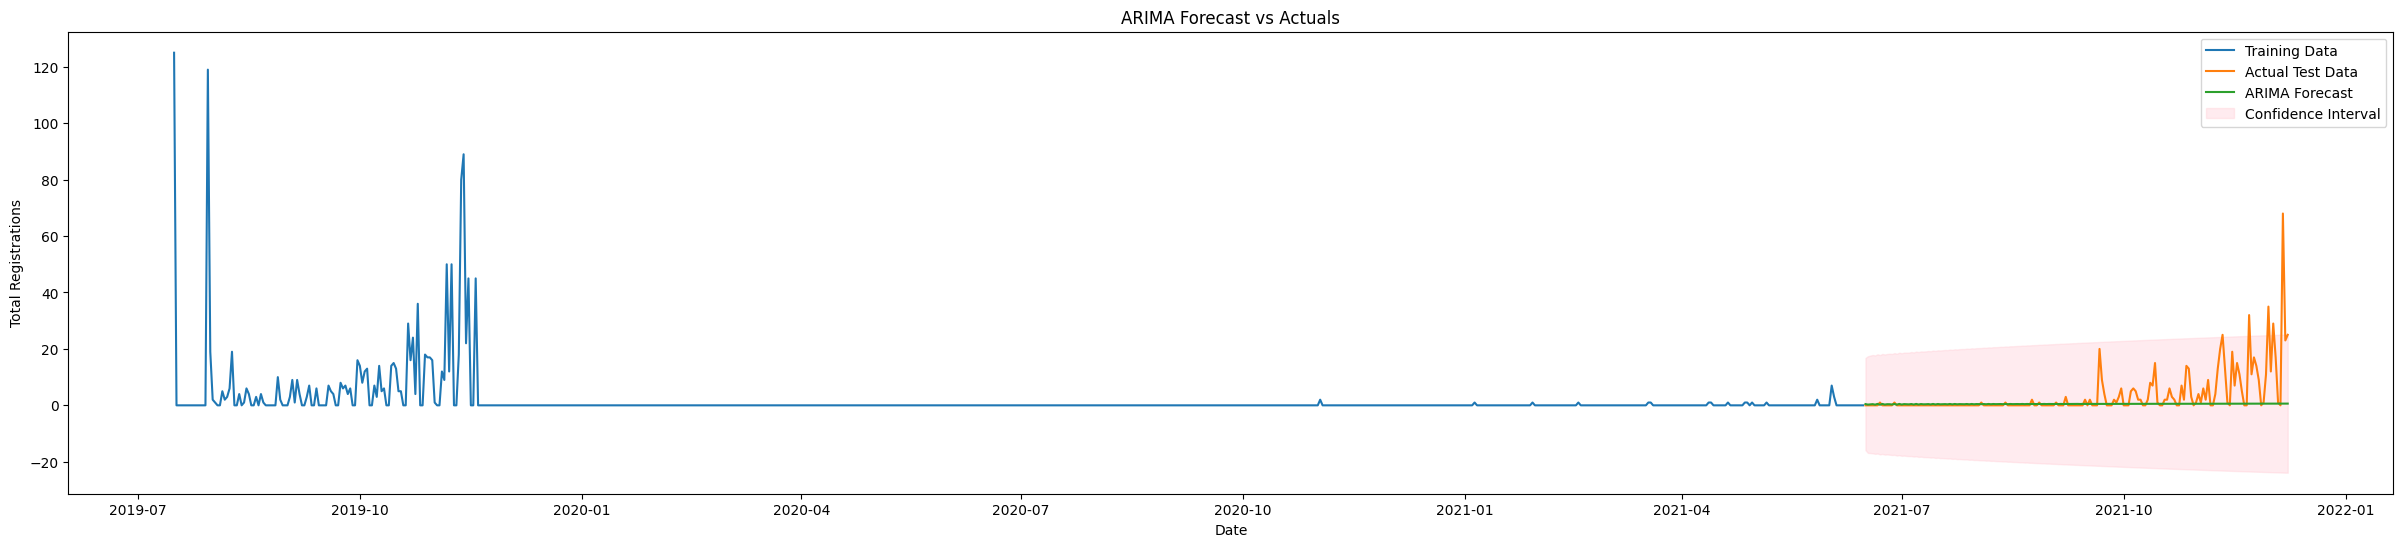

In [160]:
# IT Managers ARIMA 
train, test = split_time_series_data(complete_reg_it, split_ratio=0.8)

# For ARIMA, focusing on the endogenous variable only
train_endog_ar = train['Total Registrations']
test_endog_ar = test['Total Registrations']

# Finding the best ARIMA order
order = find_best_arima_order(train_endog_ar)

# Forecasting with ARIMA
forecast_values_arima, conf_int = arima_forecasting(train_endog_ar, order)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_ar, label='Training Data')
plt.plot(test.index, test_endog_ar, label='Actual Test Data')
plt.plot(test.index, forecast_values_arima, label='ARIMA Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


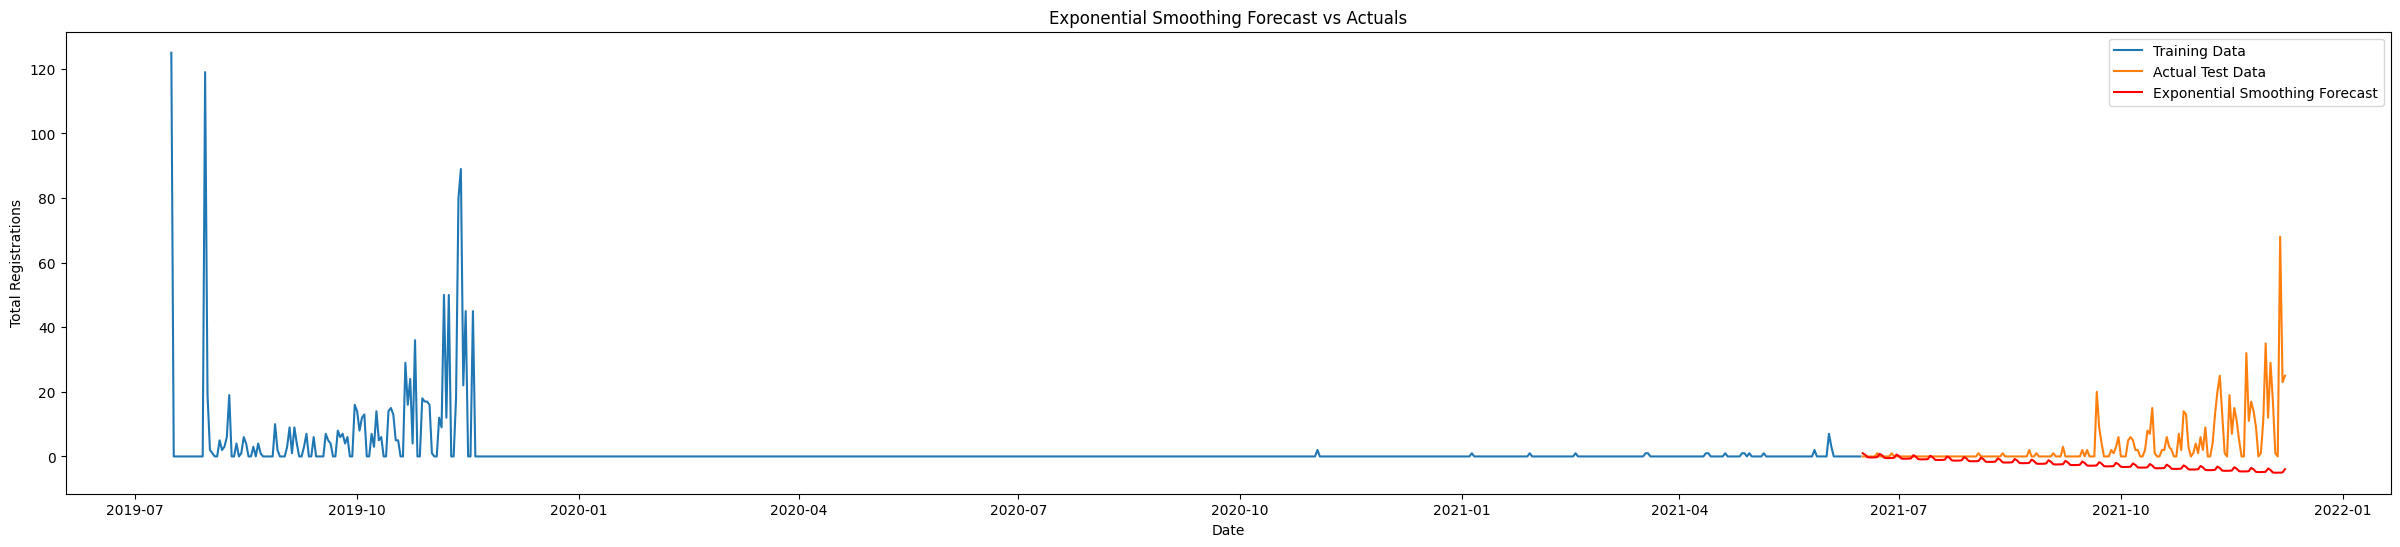

In [161]:
# IT Managers EXP
train, test = split_time_series_data(complete_reg_it, split_ratio=0.8)

train_endog_exp= train['Total Registrations']
test_endog_exp = test['Total Registrations']

forecast_values_exp = exp_smoothing(train_endog_exp)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_exp, label='Training Data')
plt.plot(test.index, test_endog_exp, label='Actual Test Data')
plt.plot(test.index, forecast_values_exp, label='Exponential Smoothing Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.show()

In [162]:
# Calculate RMSE and MAE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_endog_ar, forecast_values_arima))
mae_arima = mean_absolute_error(test_endog_ar, forecast_values_arima)

# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

#Calculate RMSE and MAE for Exponential Smoothing
rmse_exp = np.sqrt(mean_squared_error(test_endog_exp, forecast_values_exp))
mae_exp = mean_squared_error(test_endog_exp, forecast_values_exp)

# Find the maximum value across all test datasets 
max_value = max(test_endog_ar.max(), test_endog.max(), test_endog_exp.max())

# Calculate RMSE as a percentage of the max value
rmse_pct_arima = (rmse_arima / max_value) * 100
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100
rmse_pct_exp = (rmse_exp / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_arima = (mae_arima / max_value) * 100
mae_pct_sarimax = (mae_sarimax / max_value) * 100
mae_pct_exp = (mae_exp / max_value) * 100

# Print the results
print(f"ARIMA RMSE (IT): {rmse_arima:.2f}, RMSE %:  {rmse_pct_arima:.2f}%,  MAE: {mae_arima:.2f}, MAE %: {mae_pct_arima:.2f}%")
print(f"SARIMAX RMSE (IT): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")
print(f"Exponential Smoothing RMSE (IT): {rmse_exp:.2f}, RMSE %: {rmse_pct_exp:.2f}, % MAE: {mae_exp:.2f}, MAE %: {mae_pct_exp:.2f}%")

ARIMA RMSE (IT): 8.67, RMSE %:  12.75%,  MAE: 3.63, MAE %: 5.34%
SARIMAX RMSE (IT): 6.82,RMSE %:  10.02%, MAE: 3.25, MAE %:  4.79%
Exponential Smoothing RMSE (IT): 10.71, RMSE %: 15.75, % MAE: 114.71, MAE %: 168.69%


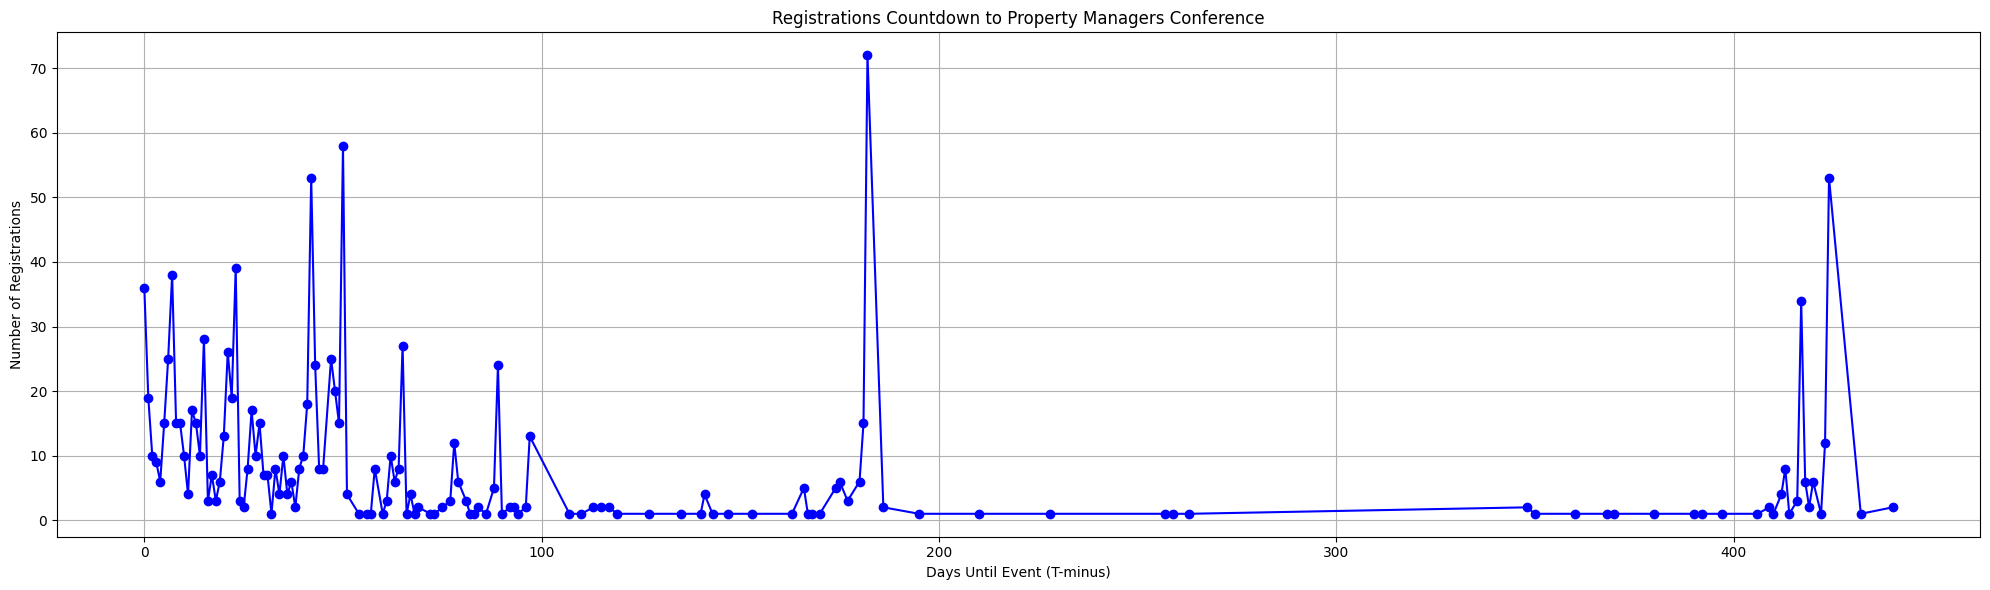

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=3318.345, Time=2.75 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3543.538, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3453.755, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3336.324, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3541.538, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=3320.375, Time=1.56 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=3319.284, Time=1.61 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=3318.484, Time=4.53 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=3318.080, Time=4.16 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=3321.935, Time=2.62 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=3316.862, Time=4.38 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=3314.951, Time=3.62 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=3316.353, Time=4.20 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=3316.686, Time=3.62 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                    Total Registrations   No. Observations:                  513
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -1366.553
Date:                                Wed, 21 Feb 2024   AIC                           2749.107
Time:                                        17:00:43   BIC                           2783.013
Sample:                                    02-06-2020   HQIC                          2762.398
                                         - 07-02-2021                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    31.2084      0.337     92.668      0.000      30.548      3

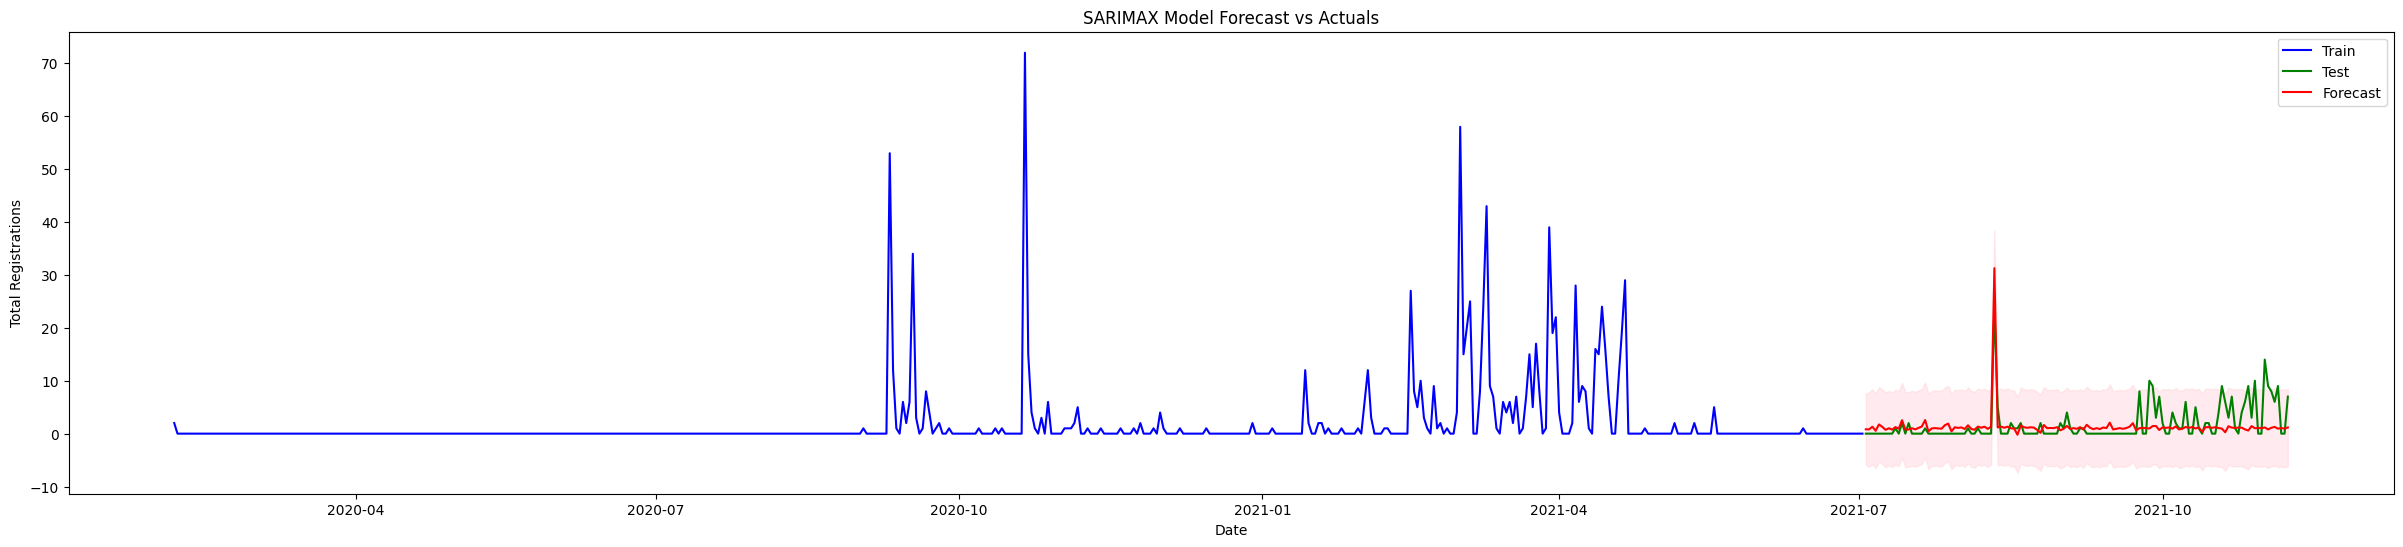

In [163]:
# Property Managers SARIMAX:
# GP21 and NP21
gp21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\GP21.csv", 'GP21', '22/04/2021')
np21 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\NP21.csv", 'NP21', '09/11/2021')

# Combine datasets 
combined_property_managers = combine_datasets(gp21, np21)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_property_managers, 'Registrations Countdown to Property Managers Conference')
daily_registrations_prop = calculate_daily_registrations(combined_property_managers)
complete_reg_prop = prepare_for_forecasting(daily_registrations_prop)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_prop)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_prop.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3351.991, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3457.387, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3368.156, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3388.391, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3332.451, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3365.625, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3333.805, Time=0.42 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3334.036, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3332.448, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3375.627, Time=0.10 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3333.853, Time=0.43 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3370.223, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3335.791, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3332.879, Time=0.52 sec

Best model:  ARIMA(1,0,2)(0,0,0)

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     Total Registrations   No. Observations:                  513
Model:                  ARIMA(1, 0, 2)   Log Likelihood               -1661.440
Date:                 Wed, 21 Feb 2024   AIC                           3332.879
Time:                         17:00:47   BIC                           3354.081
Sample:                     02-06-2020   HQIC                          3341.189
                          - 07-02-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6870      4.268      0.395      0.693      -6.679      10.053
ar.L1          0.9754      0.018     54.419      0.000       0.940       1.011
ma.L1         -0.6951      0.044    -15.692 

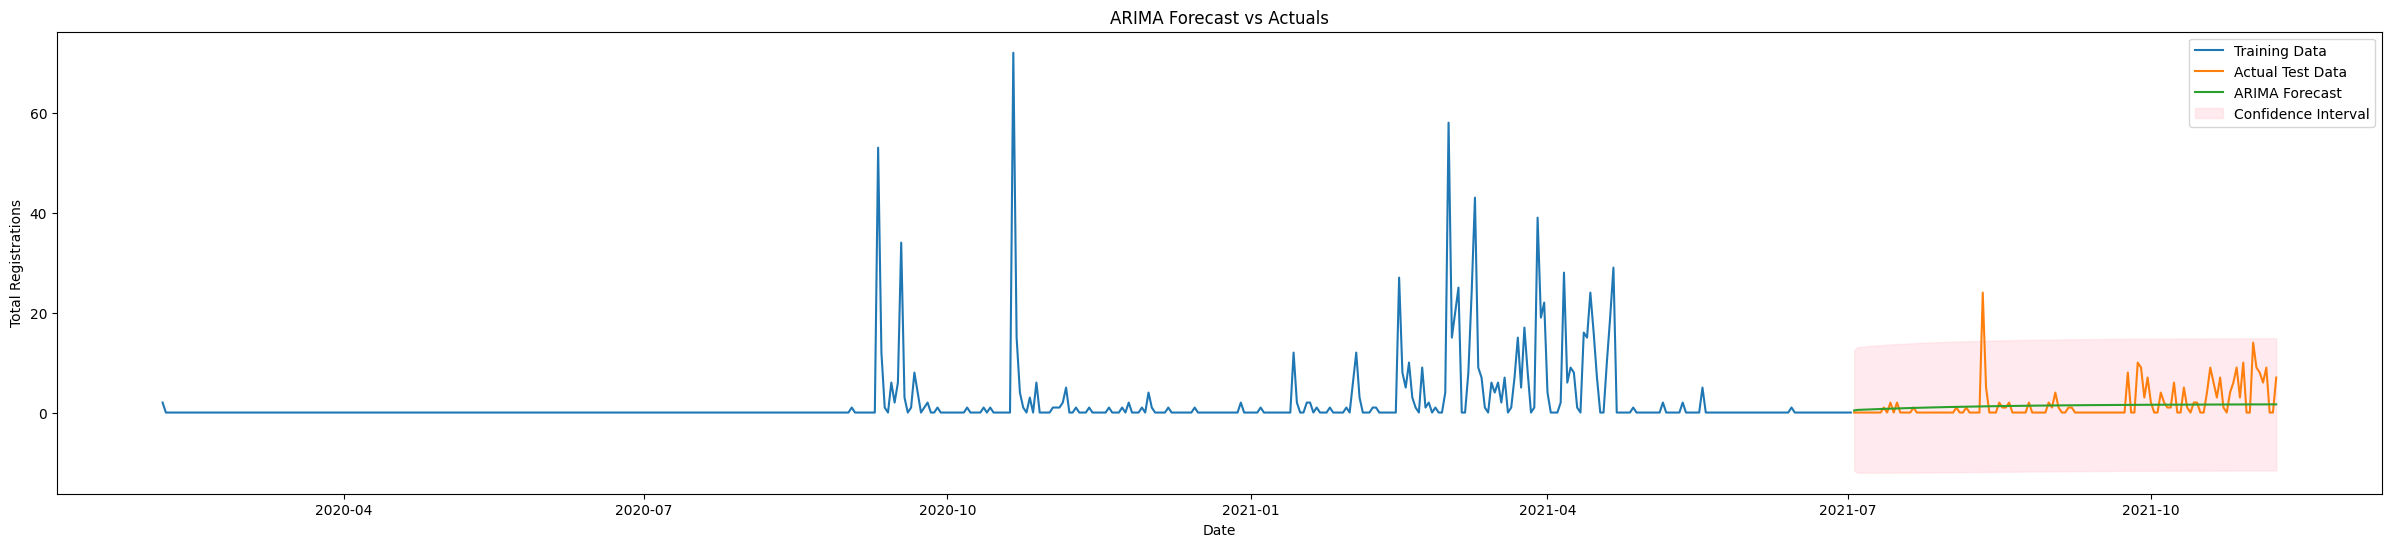

In [164]:
# Property Managers ARIMA
train, test = split_time_series_data(complete_reg_prop, split_ratio=0.8)

# For ARIMA, focusing on the endogenous variable only
train_endog_ar = train['Total Registrations']
test_endog_ar = test['Total Registrations']

# Finding the best ARIMA order
order = find_best_arima_order(train_endog_ar)

# Forecasting with ARIMA
forecast_values_arima, conf_int = arima_forecasting(train_endog_ar, order)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_ar, label='Training Data')
plt.plot(test.index, test_endog_ar, label='Actual Test Data')
plt.plot(test.index, forecast_values_arima, label='ARIMA Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


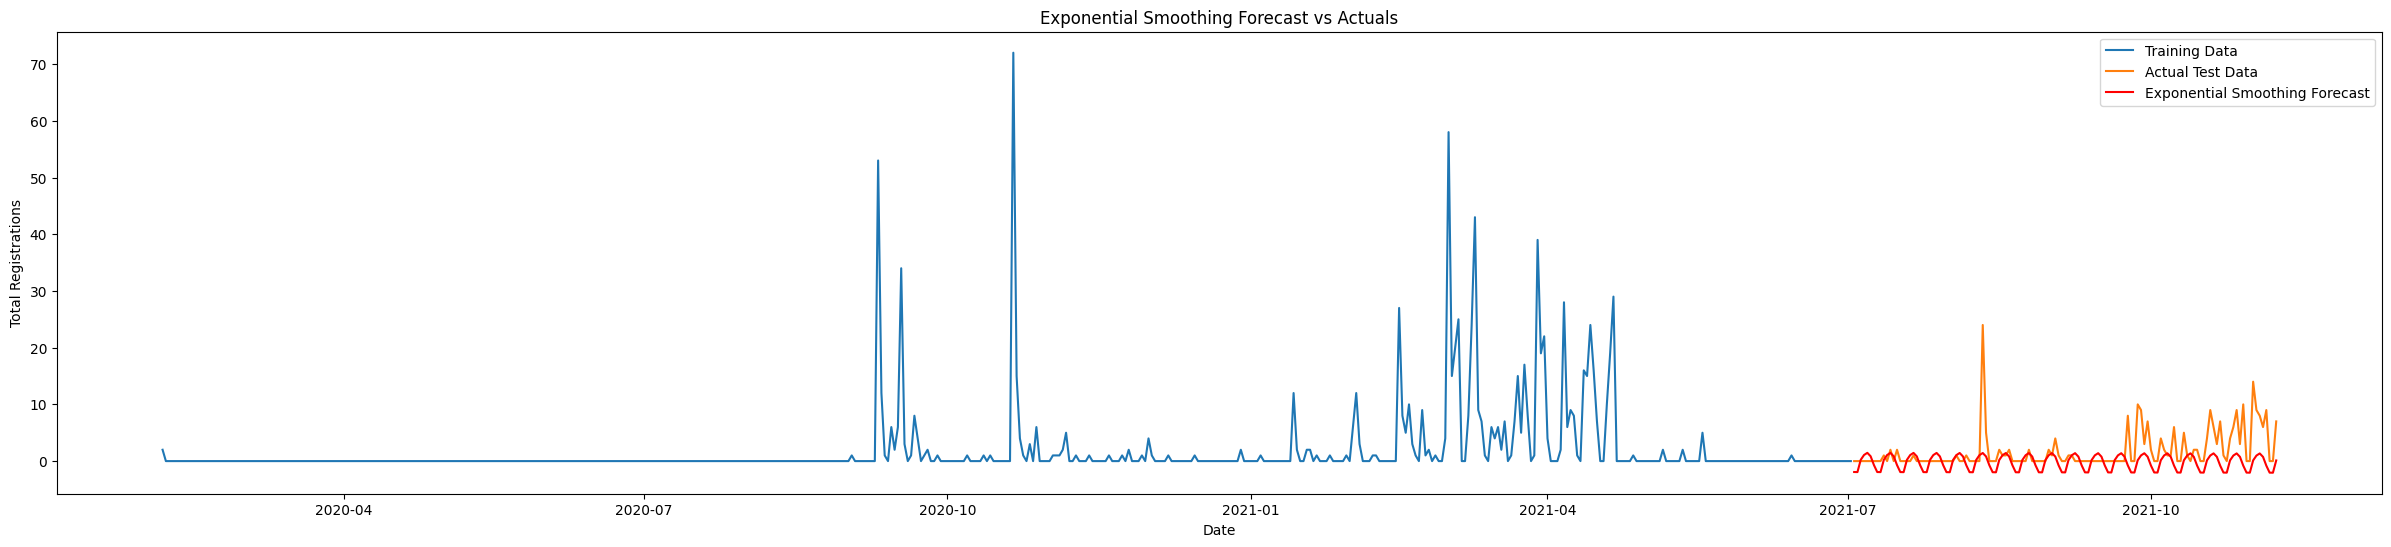

In [165]:
# Property Managers EXP
train, test = split_time_series_data(complete_reg_prop, split_ratio=0.8)

train_endog_exp= train['Total Registrations']
test_endog_exp = test['Total Registrations']

forecast_values_exp = exp_smoothing(train_endog_exp)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_exp, label='Training Data')
plt.plot(test.index, test_endog_exp, label='Actual Test Data')
plt.plot(test.index, forecast_values_exp, label='Exponential Smoothing Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.show()

In [166]:
# Calculate RMSE and MAE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_endog_ar, forecast_values_arima))
mae_arima = mean_absolute_error(test_endog_ar, forecast_values_arima)

# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

#Calculate RMSE and MAE for Exponential Smoothing
rmse_exp = np.sqrt(mean_squared_error(test_endog_exp, forecast_values_exp))
mae_exp = mean_squared_error(test_endog_exp, forecast_values_exp)

# Find the maximum value across all test datasets 
max_value = max(test_endog_ar.max(), test_endog.max(), test_endog_exp.max())

# Calculate RMSE as a percentage of the max value
rmse_pct_arima = (rmse_arima / max_value) * 100
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100
rmse_pct_exp = (rmse_exp / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_arima = (mae_arima / max_value) * 100
mae_pct_sarimax = (mae_sarimax / max_value) * 100
mae_pct_exp = (mae_exp / max_value) * 100

# Print the results
print(f"ARIMA RMSE (Property): {rmse_arima:.2f}, RMSE %:  {rmse_pct_arima:.2f}%,  MAE: {mae_arima:.2f}, MAE %: {mae_pct_arima:.2f}%")
print(f"SARIMAX RMSE (Property]): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")
print(f"Exponential Smoothing RMSE (Property): {rmse_exp:.2f}, RMSE %: {rmse_pct_exp:.2f}, % MAE: {mae_exp:.2f}, MAE %: {mae_pct_exp:.2f}%")

ARIMA RMSE (Property): 3.44, RMSE %:  14.32%,  MAE: 2.06, MAE %: 8.57%
SARIMAX RMSE (Property]): 3.05,RMSE %:  12.70%, MAE: 1.96, MAE %:  8.18%
Exponential Smoothing RMSE (Property): 3.93, RMSE %: 16.36, % MAE: 15.41, MAE %: 64.20%


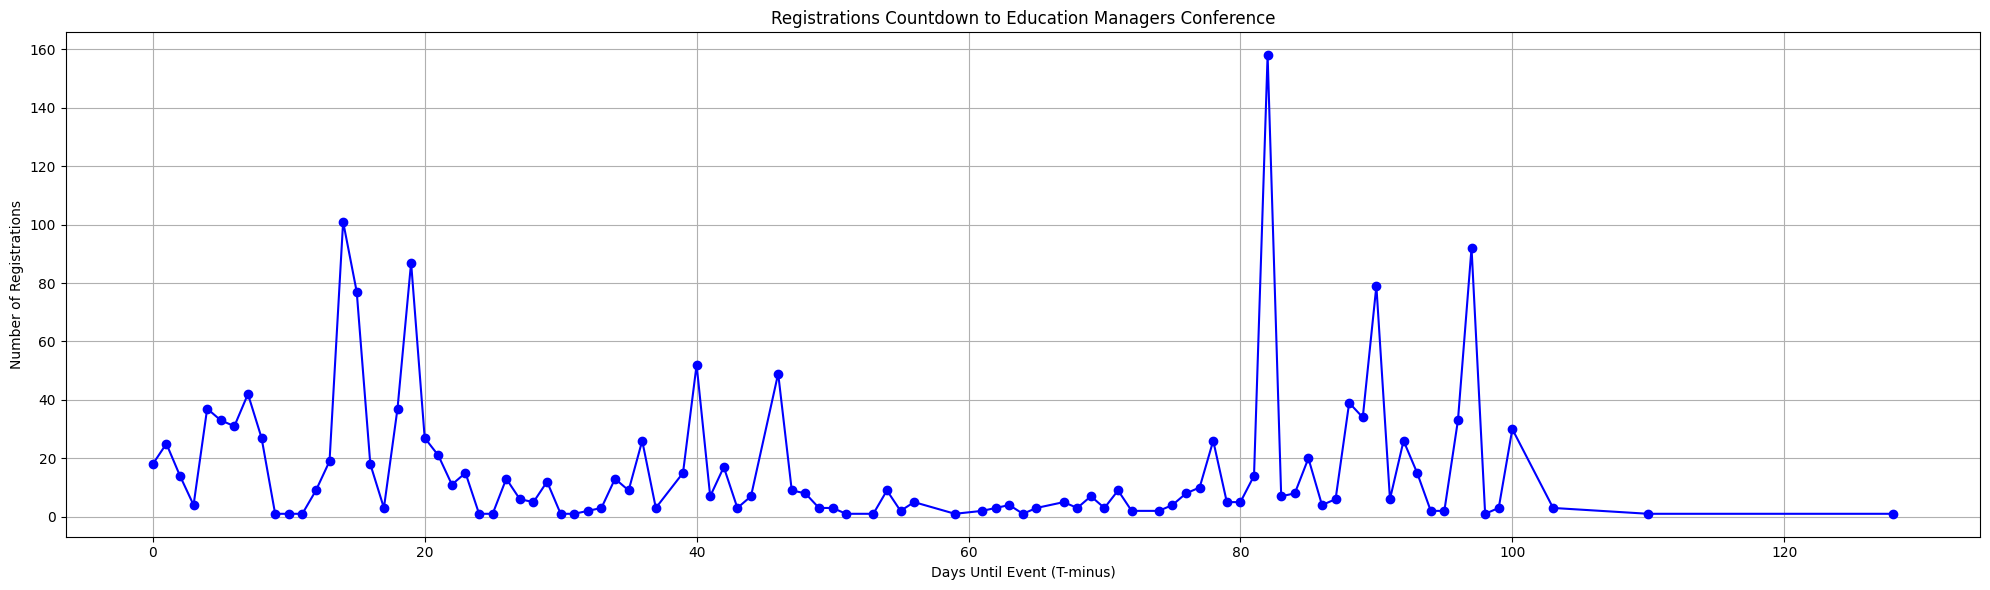

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=2806.245, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2977.055, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2919.195, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2806.917, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2975.099, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=2804.275, Time=1.07 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=2803.828, Time=0.42 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=2804.245, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=2805.131, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=2802.411, Time=0.26 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=2803.907, Time=0.55 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=2803.915, Time=0.55 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=2805.906, Time=0.89 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2805.014, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     Total Registrations   No. Observations:                  359
Model:                SARIMAX(3, 1, 3)   Log Likelihood               -1224.800
Date:                 Wed, 21 Feb 2024   AIC                           2465.600
Time:                         17:01:27   BIC                           2496.644
Sample:                     03-16-2022   HQIC                          2477.947
                          - 03-09-2023                                         
Covariance Type:                   opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Advertisement    54.5542      1.013     53.853      0.000      52.569      56.540
ar.L1            -0.0896      0.055     -1.632      0.103      -0.197       0.018
ar.L2            -0.9893      0.

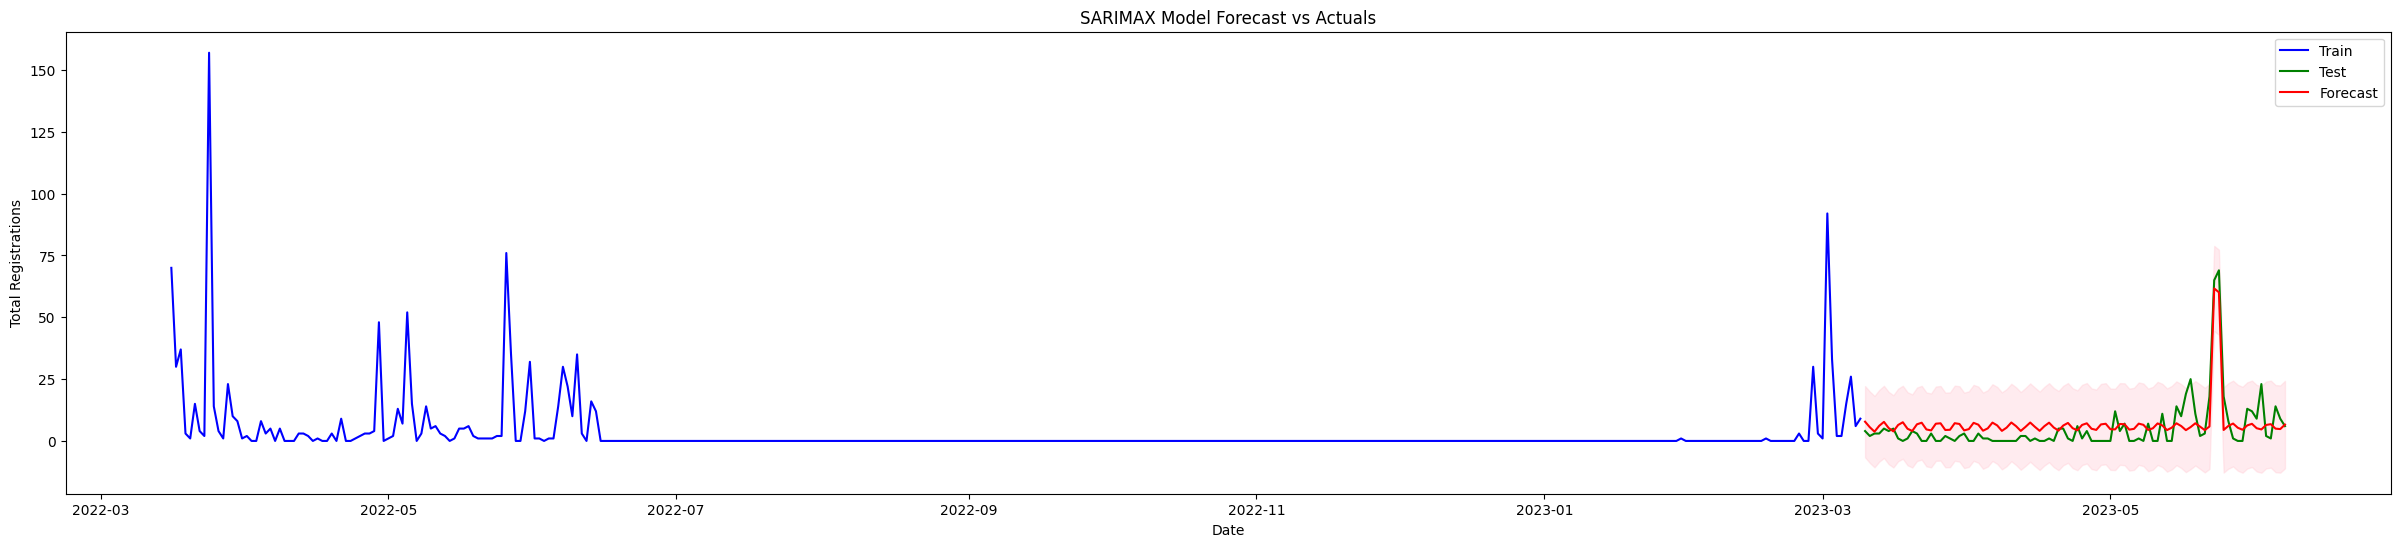

In [167]:
# Education Managers SARIMAX
# SRM22 and SRM23
srm22 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM22.csv", 'SRM22', '15/06/2022')
srm23 = read_and_preprocess(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\SRM23.csv", 'SRM23', '08/06/2023')

# Combine datasets
combined_ed_managers = combine_datasets(srm22, srm23)

# Proceed with analysis and plotting
plot_registrations_countdown(combined_ed_managers, 'Registrations Countdown to Education Managers Conference')
daily_registrations_ed = calculate_daily_registrations(combined_ed_managers)
complete_reg_ed = prepare_for_forecasting(daily_registrations_ed)

# Split the data into training and testing sets
train_endog, train_exog, test_endog, test_exog = split_data_for_forecasting(complete_reg_ed)

# Use Auto ARIMA to find the optimal SARIMAX parameters
order, seasonal_order = auto_arima_forecasting(train_endog, train_exog)

# Fit the SARIMAX model using the optimal parameters
forecast_values, conf_int = sarimax_forecasting(train_endog, train_exog, test_exog, order, seasonal_order)

test_df = test_exog.copy()
test_df['Total Registrations'] = test_endog.values

# Plot the forecast against actual values
plot_forecast_vs_actuals(complete_reg_ed.iloc[:len(train_endog)], test_df, forecast_values, conf_int)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2805.014, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2977.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2917.748, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2804.920, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2975.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2804.417, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2805.131, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2802.959, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2803.421, Time=0.71 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2803.537, Time=0.59 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2799.866, Time=0.63 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2801.443, Time=0.85 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2805.512, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : 

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     Total Registrations   No. Observations:                  359
Model:                  ARIMA(1, 1, 4)   Log Likelihood               -1393.012
Date:                 Wed, 21 Feb 2024   AIC                           2798.023
Time:                         17:01:44   BIC                           2821.306
Sample:                     03-16-2022   HQIC                          2807.283
                          - 03-09-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8934      0.086    -10.435      0.000      -1.061      -0.726
ma.L1          0.0980      0.103      0.949      0.343      -0.104       0.300
ma.L2         -0.9320      0.059    -15.755 

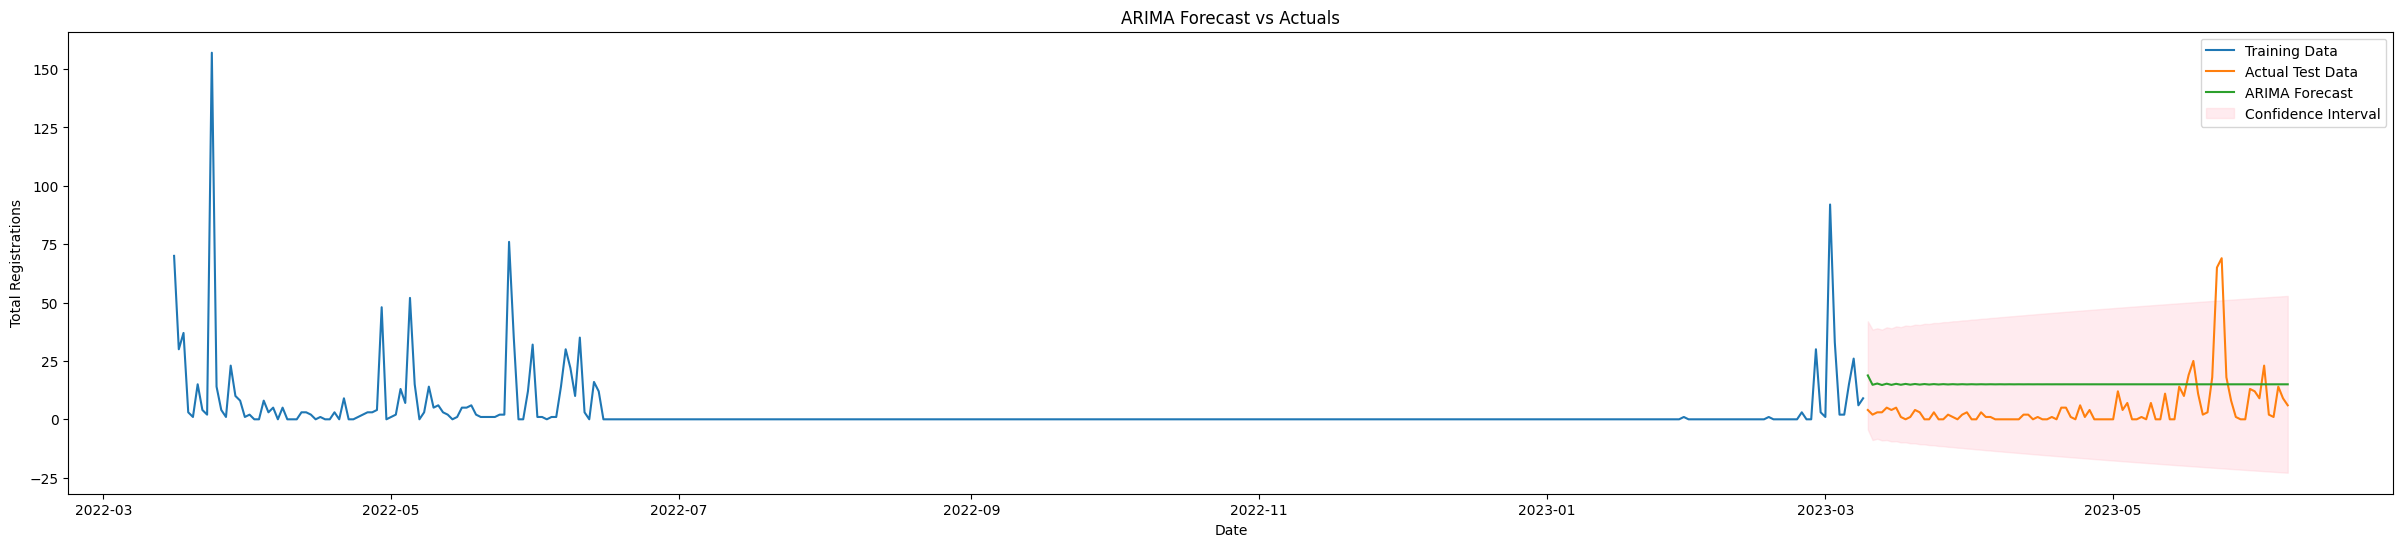

In [168]:
# Education Managers ARIMA
train, test = split_time_series_data(complete_reg_ed, split_ratio=0.8)

# For ARIMA, focusing on the endogenous variable only
train_endog_ar = train['Total Registrations']
test_endog_ar = test['Total Registrations']

# Finding the best ARIMA order
order = find_best_arima_order(train_endog_ar)

# Forecasting with ARIMA
forecast_values_arima, conf_int = arima_forecasting(train_endog_ar, order)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_ar, label='Training Data')
plt.plot(test.index, test_endog_ar, label='Actual Test Data')
plt.plot(test.index, forecast_values_arima, label='ARIMA Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('ARIMA Forecast vs Actuals')
plt.show()

c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


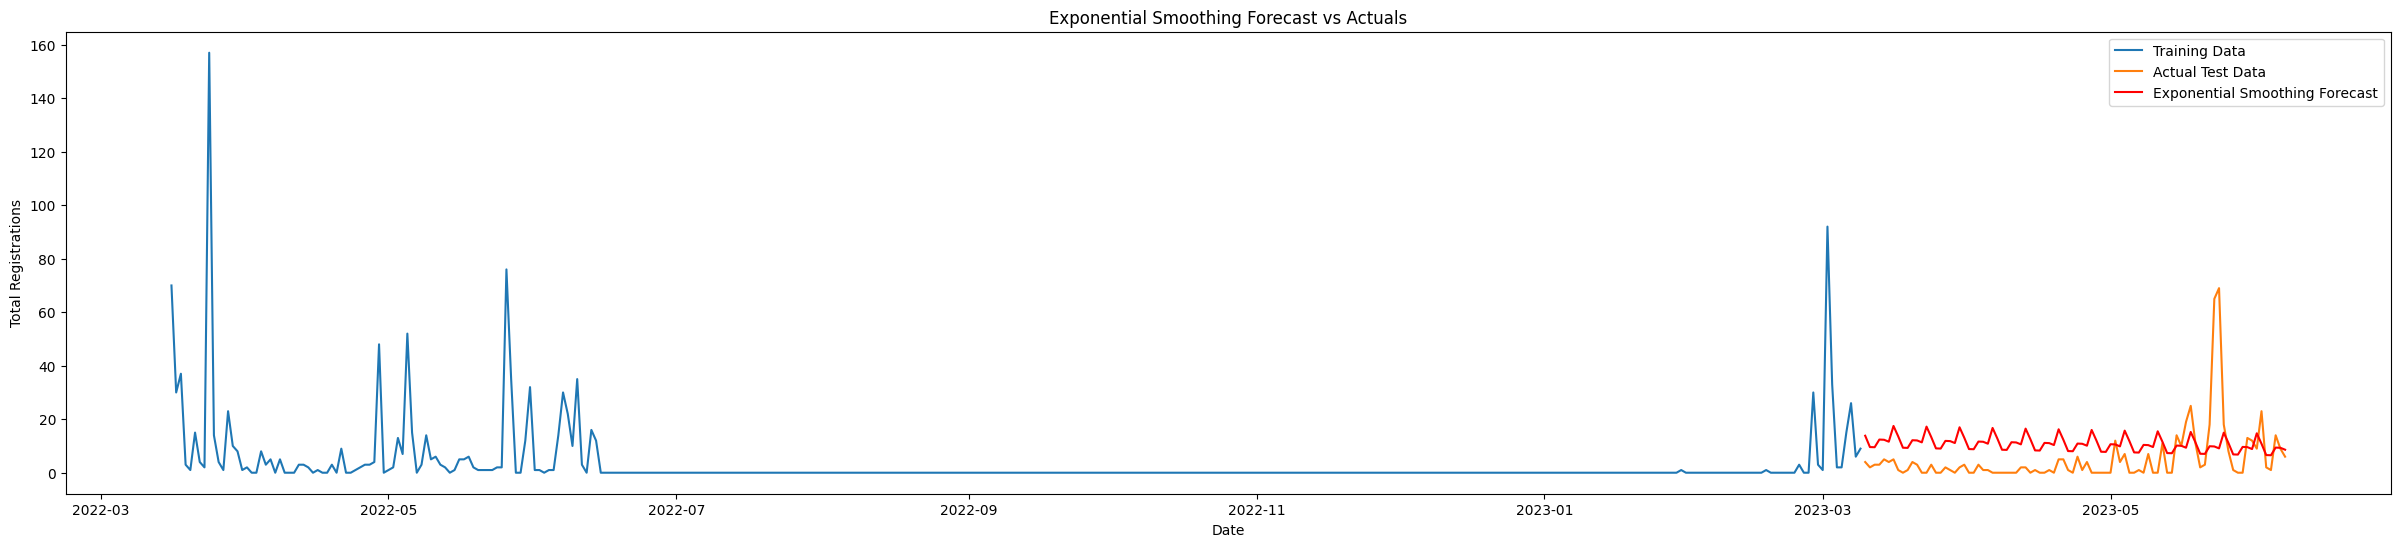

In [169]:
# Education Managers EXP
train, test = split_time_series_data(complete_reg_ed, split_ratio=0.8)

train_endog_exp= train['Total Registrations']
test_endog_exp = test['Total Registrations']

forecast_values_exp = exp_smoothing(train_endog_exp)

# Plotting the results
plt.figure(figsize=(30, 6))
plt.plot(train.index, train_endog_exp, label='Training Data')
plt.plot(test.index, test_endog_exp, label='Actual Test Data')
plt.plot(test.index, forecast_values_exp, label='Exponential Smoothing Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Registrations')
plt.title('Exponential Smoothing Forecast vs Actuals')
plt.show()

In [170]:
# Calculate RMSE and MAE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_endog_ar, forecast_values_arima))
mae_arima = mean_absolute_error(test_endog_ar, forecast_values_arima)

# Calculate RMSE and MAE for SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(test_endog, forecast_values))
mae_sarimax = mean_absolute_error(test_endog, forecast_values)

#Calculate RMSE and MAE for Exponential Smoothing
rmse_exp = np.sqrt(mean_squared_error(test_endog_exp, forecast_values_exp))
mae_exp = mean_squared_error(test_endog_exp, forecast_values_exp)

# Find the maximum value across all test datasets 
max_value = max(test_endog_ar.max(), test_endog.max(), test_endog_exp.max())

# Calculate RMSE as a percentage of the max value
rmse_pct_arima = (rmse_arima / max_value) * 100
rmse_pct_sarimax = (rmse_sarimax / max_value) * 100
rmse_pct_exp = (rmse_exp / max_value) * 100

# Calculate MAE as a percentage of the max value
mae_pct_arima = (mae_arima / max_value) * 100
mae_pct_sarimax = (mae_sarimax / max_value) * 100
mae_pct_exp = (mae_exp / max_value) * 100

# Print the results
print(f"ARIMA RMSE (Education): {rmse_arima:.2f}, RMSE %:  {rmse_pct_arima:.2f}%,  MAE: {mae_arima:.2f}, MAE %: {mae_pct_arima:.2f}%")
print(f"SARIMAX RMSE (Education): {rmse_sarimax:.2f},RMSE %: {rmse_pct_sarimax: .2f}%, MAE: {mae_sarimax:.2f}, MAE %: {mae_pct_sarimax: .2f}%")
print(f"Exponential Smoothing RMSE (Education): {rmse_exp:.2f}, RMSE %: {rmse_pct_exp:.2f}, % MAE: {mae_exp:.2f}, MAE %: {mae_pct_exp:.2f}%")

ARIMA RMSE (Education): 14.59, RMSE %:  21.14%,  MAE: 12.71, MAE %: 18.42%
SARIMAX RMSE (Education): 6.13,RMSE %:  8.88%, MAE: 5.15, MAE %:  7.47%
Exponential Smoothing RMSE (Education): 12.46, RMSE %: 18.06, % MAE: 155.34, MAE %: 225.13%
